# VIPERS SHAM Project

This notebook is part of the VIPERS-SHAM project:
http://arxiv.org/abs/xxxxxxx

Copyright 2019 by Ben Granett, granett@gmail.com
All rights reserved.
This file is released under the "MIT License Agreement". Please see the LICENSE
file that should have been included as part of this package.

In [1]:
%matplotlib inline
import sys
import os
import logging
from matplotlib import pyplot as plt
plt.style.use("small.style")
from matplotlib.ticker import FormatStrFormatter,ScalarFormatter
from matplotlib import colors,cm, ticker

import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
from scipy import interpolate, integrate
import emcee
import progressbar

import growthcalc
import load
import utils
import emulator

In [2]:
nsteps = 1000
samples = ['sdss','L1','L2','L3','L4']
redshifts = {'sdss':.06, 'L1':0.6, 'L2':0.7, 'L3':0.8, 'L4':0.9}
rmin = 1

In [3]:
def decomp(cmat, thresh=.1):
    u,s,v = np.linalg.svd(cmat)
    cut = np.abs(s).max()*thresh
    o = np.abs(s)>cut
    s = s[o]
    v = v[o]
    return s, v

In [4]:
r_sdss,wp_sdss,cov_sdss = load.load_sdss()
sel = r_sdss > rmin
r_sdss = r_sdss[sel]
wp_sdss = wp_sdss[sel]
cov_sdss = cov_sdss[sel,:][:,sel]

s,v = decomp(cov_sdss)

data = [(r_sdss, wp_sdss, s, v)]

for sample in samples[1:]:
    r,wp = np.loadtxt('../data/vipers/wp_sM{sample}.txt'.format(sample=sample[1]), unpack=True)
    cmat = np.loadtxt('../data/vipers/cov_{sample}.txt'.format(sample=sample))
    sel = r > rmin
    r = r[sel]
    wp = wp[sel]
    cmat = cmat[sel,:][:,sel]
    s, v = decomp(cmat)
    data.append((r, wp, s, v))

In [5]:
shamdata = {}
for sample in ['sdss','L1','L2','L3','L4']:
    sham = load.load_sham(sample=sample, template="../data/sham400/nz_{sample}/wp_snap{snapshot:7.5f}.txt")
    snapshots = sham.keys()
    snapshots.sort()
    for key in snapshots:
        r, wp = sham[key]
        sel = r > 1
        r = r[sel]
        wp = wp[sel]
        if not sample in shamdata:
            shamdata[sample] = []
        shamdata[sample].append((key, r, wp))

INFO:root:loaded ../data/sham400/nz_sdss/wp_snap0.53000.txt
INFO:root:loaded ../data/sham400/nz_sdss/wp_snap0.62230.txt
INFO:root:loaded ../data/sham400/nz_sdss/wp_snap0.66430.txt
INFO:root:loaded ../data/sham400/nz_sdss/wp_snap0.71240.txt
INFO:root:loaded ../data/sham400/nz_sdss/wp_snap0.77240.txt
INFO:root:loaded ../data/sham400/nz_sdss/wp_snap0.83240.txt
INFO:root:loaded ../data/sham400/nz_sdss/wp_snap0.90740.txt
INFO:root:loaded ../data/sham400/nz_sdss/wp_snap1.00000.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.44200.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.50000.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.53000.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.55630.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.58640.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.62230.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.66430.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.71240.txt
INFO:root:loaded ../data/sham400/nz_L1/wp_snap0.77240.tx

In [6]:
a_samples = []
interpolators = []
for key in samples:
    y = []
    x = []
    for a,r,w in shamdata[key]:
        sel = r > 1
        r = r[sel]
        y.append(w[sel])
        x.append(a)
    y = np.array(y)
    x = np.array(x)
    f = emulator.WpInterpolator(x, r, y)
    interpolators.append(f)
    a_samples.append(1./(1+redshifts[key]))
a_samples = np.array(a_samples)
emu = emulator.Emulator(a_samples, interpolators)

INFO:root:growth range -0.452318 5.000000
INFO:root:growth sig8 0.822800


In [7]:
def conf_interval(x, y, p=0.68, alpha = 0.99):
    """ """
    best = y.argmax()
    x0 = x[best]
    ybest = y[best]

    h = ybest
    t = np.sum(y)*p
    
    while np.sum(y[y>h]) < t:
        h *= alpha

    s = x[np.where(y>h)]
    low = s[0]
    high = s[-1]
    
    return x0, x0-low, high-x0

In [8]:
def loglike(p, emu, data):
    """ """
    sig8, gamma = p
    if gamma < -5:
        return -np.infty
    if gamma > 5:
        return -np.infty
    if sig8 < 0:
        return -np.infty

    try:
        model = emu(gamma, sig8)
    except ValueError:
        return -np.infty
    
    assert len(model) == len(data)
    
    chi2 = 0
    for i in range(len(data)):
        r,wp,s,v = data[i]
        rsham, wsham = model[i]
        d = np.dot(v, wp - wsham)
        chi2 += np.sum(d**2 / s)
        
    return -chi2/2.

def loglike_gamma(p, emu, data):
    """ """
    gamma = p
    if gamma < -5:
        return -np.infty
    if gamma > 5:
        return -np.infty
    
    try:
        model = emu(gamma, None)
    except ValueError:
        return -np.infty

    assert len(model) == len(data)
    
    chi2 = 0
    for i in range(len(data)):
        r,wp,s,v = data[i]
        rsham, wsham = model[i]
        d = np.dot(v, wp - wsham)
        chi2 += np.sum(d**2 / s)
        
    return -chi2/2.


def loglike_s8(p, emu, data):
    """ """
    s8 = p
    try:
        model = emu(None, s8)
    except ValueError:
        return -np.infty

    assert len(model) == len(data)
    
    chi2 = 0
    for i in range(len(data)):
        r,wp,s,v = data[i]
        rsham, wsham = model[i]
        d = np.dot(v, wp - wsham)
        chi2 += np.sum(d**2 / s)
        
    return -chi2/2.


In [9]:
def run_chain(sampler, p0, nsteps=1000):
    """ """
    bar = progressbar.ProgressBar(max_value=nsteps)
    for i, result in enumerate(sampler.sample(p0, iterations=nsteps)):
        bar.update(i)
    return result

In [10]:
ndim, nwalkers = 2, 100
p0 = np.random.normal(0, 0.01, (nwalkers,ndim)) + np.array([0.8, 0.55])

sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike, args=[emu, data])

pos, prob, state = run_chain(sampler, p0, 100)

sampler.reset()

pos, prob, state = run_chain(sampler, pos, nsteps)

 99% (999 of 1000) |#################### | Elapsed Time: 0:02:31 ETA:   0:00:00

In [11]:
gamma = np.linspace(-1,2.5,2000)
ll = np.zeros(len(gamma))
bar = progressbar.ProgressBar()
for i in bar(range(len(gamma))):
    ll[i] = loglike_gamma(gamma[i], emu, data)
ll = np.exp(np.array(ll))
ll = ll / np.sum(ll) / (gamma[1]-gamma[0])

100% (2000 of 2000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02


In [12]:
a,b,c = conf_interval(gamma, ll)
print a,b,c
print a, np.sqrt((b**2+c**2)/2.)

0.5740370185092547 0.24862431215607805 0.31165582791395696
0.5740370185092547 0.2819072575048547


In [13]:
sig8 = np.linspace(0.5,1.2, 2000)
ll_s8 = np.zeros(len(sig8))
bar = progressbar.ProgressBar()
for i in bar(range(len(sig8))):
    ll_s8[i] = loglike_s8(sig8[i], emu, data)
ll_s8 = np.exp(np.array(ll_s8))
ll_s8 = ll_s8 / np.sum(ll_s8) / (sig8[1]-sig8[0])

100% (2000 of 2000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02


In [14]:
a,b,c = conf_interval(sig8, ll_s8)
print a,b,c
print a, np.sqrt((b**2+c**2)/2.)

0.8491245622811405 0.04272136068034016 0.0406203101550775
0.8491245622811405 0.04168407522948306


In [15]:
def plot_lim(ax, t, g, s):
    t = np.array(t,dtype='d')
    xx = []
    yy = []
    for i,c in enumerate(t):
        k = c.searchsorted(1)
        if k > 0 and k < len(s):
            yy.append(s[k])
            xx.append(g[i])
    ax.plot(xx,yy, c='k', dashes=[1,1,1,1])

gamma (0.5740370185092547, 0.24862431215607805, 0.31165582791395696)
sig8 (0.8491245622811405, 0.04272136068034016, 0.0406203101550775)


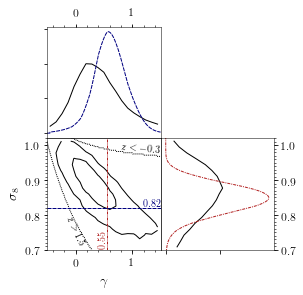

In [16]:
from matplotlib import gridspec

bins = (
    np.linspace(0.7, 1.02, 20),
    np.linspace(-0.5, 1.5, 20)
)
ext = [bins[1][0],bins[1][-1],bins[0][0],bins[0][-1]]
h, ex, ey = np.histogram2d(*sampler.flatchain.T, bins=bins)
h = h.T


h_sig,e_s = np.histogram(sampler.flatchain.T[0], bins=bins[0], density=True)
h_gam,e_g = np.histogram(sampler.flatchain.T[1], bins=bins[1], density=True)


levels = utils.lowerwater(h, (0.866, 0.395))
a = (ey[1]-ey[0])/(ex[1]-ex[0])

fig = plt.figure(figsize=(4.2,4))

gs = gridspec.GridSpec(2, 2)
gs.update(right=0.9, top=0.9, hspace=0,wspace=0)

ax1 = plt.subplot(gs[1,0])
ax2 = plt.subplot(gs[0,0])
ax3 = plt.subplot(gs[1,1])


g = np.linspace(-0.5,1.5,200)
s = np.linspace(0.5,1.2,200)
zmin,zmax = emu.check_bounds(g,s)
plot_lim(ax1, zmin<-0.3, g, s)
plot_lim(ax1, zmax<1.5, g, s)
ax1.text(-0.2,0.78,"$z>1.5$", rotation=-65)
ax1.text(0.8,0.99,"$z<-0.3$", rotation=-5)

ax1.contour(h.T, levels=levels, colors='k', extent=ext, origin='lower')
ax1.axvline(0.55, dashes=[3,1,1,1], c='firebrick')
ax1.axhline(0.82, dashes=[4,1], c='navy')

ax1.set_xlim(ext[0],ext[1])
ax1.set_ylim(ext[2],ext[3])


ax2.plot((e_g[1:]+e_g[:-1])/2., h_gam, c='k')
ax2.plot(gamma, ll, c='navy', dashes=[4,1])
print "gamma", conf_interval(gamma, ll)

ax2.set_xlim(ext[0],ext[1])

ax3.plot(h_sig, (e_s[1:]+e_s[:-1])/2., c='k')
ax3.plot(ll_s8, sig8, c='firebrick', dashes=[3,1,1,1])

print "sig8", conf_interval(sig8, ll_s8)

ax3.set_ylim(ext[2],ext[3])

plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)

ax2.xaxis.tick_top()
ax3.yaxis.tick_right()

ax1.set_ylabel("$\sigma_8$")
ax1.set_xlabel("$\gamma$")

ax1.text(0.55, 0.7, "0.55", rotation=90, va='bottom', ha='right', color='firebrick')
ax1.text(1.5,0.82, "0.82", va='bottom', ha='right', color='navy')

ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
ax3.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))

plt.savefig("../figs/fig9.pdf")